In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects
import numpy as np
from dataclasses import dataclass
import pandas as pd
import vice
from scipy.interpolate import interp1d
from scipy.integrate import quad
import random

using vice version  1.4.0.dev1


In [3]:
from surp.analysis.vice_model import vice_model
from surp.analysis import apogee_analysis as aah
import seaborn as sns
import arya


In [4]:
fiducial = vice_model("../out/C11_f0.2_eta1_beta0.001.json")
gaussian = vice_model("../out/C11_f0.2_eta1_beta0.001_gaussian_dt0.05.json")

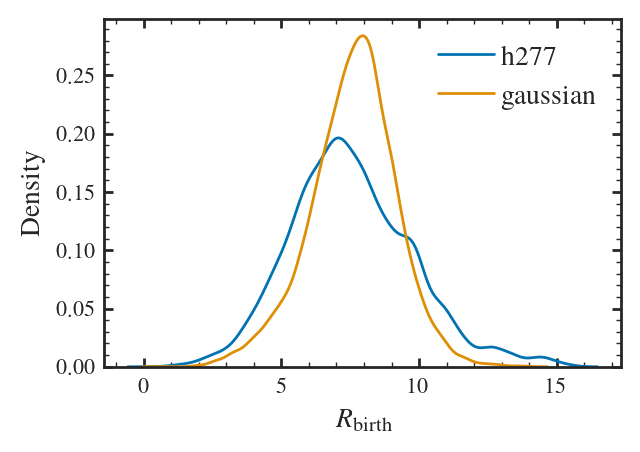

In [7]:
sns.kdeplot(fiducial.stars, x="r_origin", label="h277")
sns.kdeplot(gaussian.stars, x="r_origin", label="gaussian")
plt.legend()
plt.xlabel(r"$R_{\rm birth}$")

plt.savefig("migration_solar.pdf")

In [8]:
N = 6000
x = fiducial.stars_unsampled["mass"]

idxs = random.choices(np.arange(len(x)), weights=x, k=N)
fiducial_all_stars = fiducial.stars_unsampled.iloc[idxs]


N = 6000
x = gaussian.stars_unsampled["mass"]

idxs = random.choices(np.arange(len(x)), weights=x, k=N)
gaussian_all_stars = gaussian.stars_unsampled.iloc[idxs]

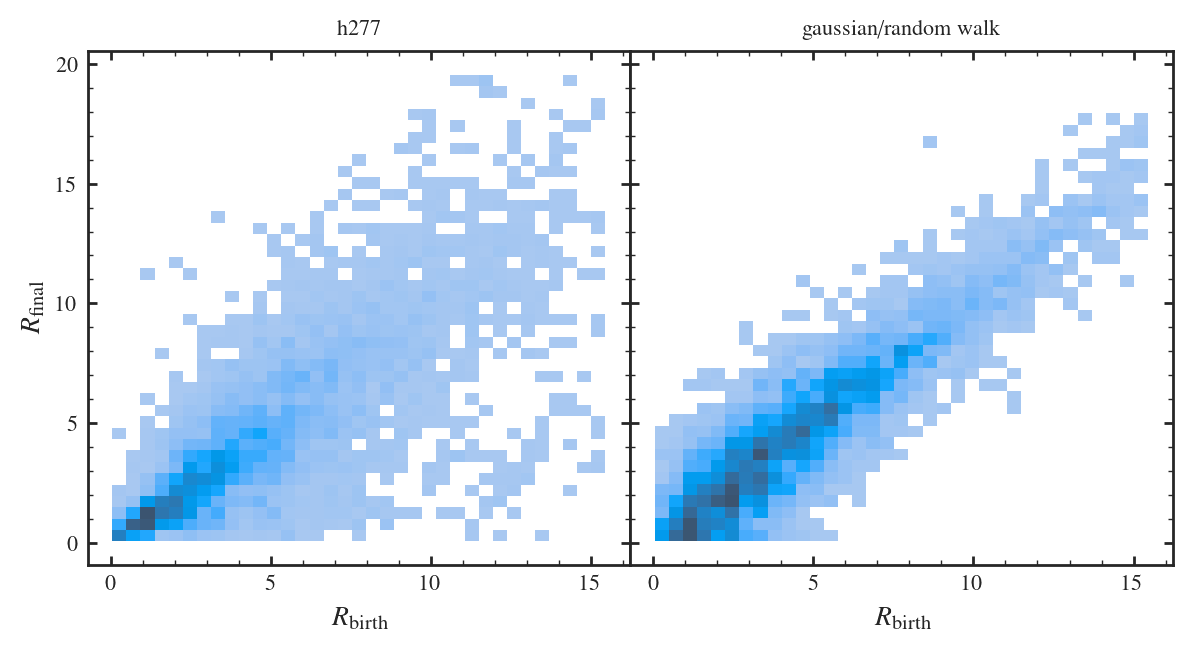

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(7, 10/3), sharey=True, gridspec_kw={"wspace": 0})

plt.sca(axs[0])
sns.histplot(fiducial_all_stars, x="r_origin", y="r_final")
plt.xlabel(r"$R_{\rm birth}$")
plt.ylabel(r"$R_{\rm final}$")

plt.title("h277")


plt.sca(axs[1])
sns.histplot(gaussian_all_stars, x="r_origin", y="r_final")

plt.xlabel(r"$R_{\rm birth}$")
plt.ylabel(r"$R_{\rm final}$")

plt.title("gaussian/random walk")

plt.savefig("hist2d_migration.pdf")

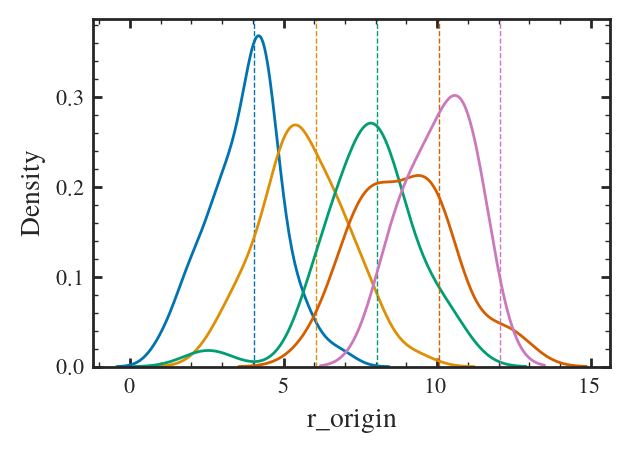

In [23]:
for zone_id in [40, 60, 80, 100, 120]:
    df = gaussian_all_stars[gaussian_all_stars.zone_final == zone_id]
    p = sns.kdeplot(df, x="r_origin")
    plt.axvline(zone_id/10 + 0.05, color=plt.gca().lines[-1].get_color(), ls="--", lw=0.5)


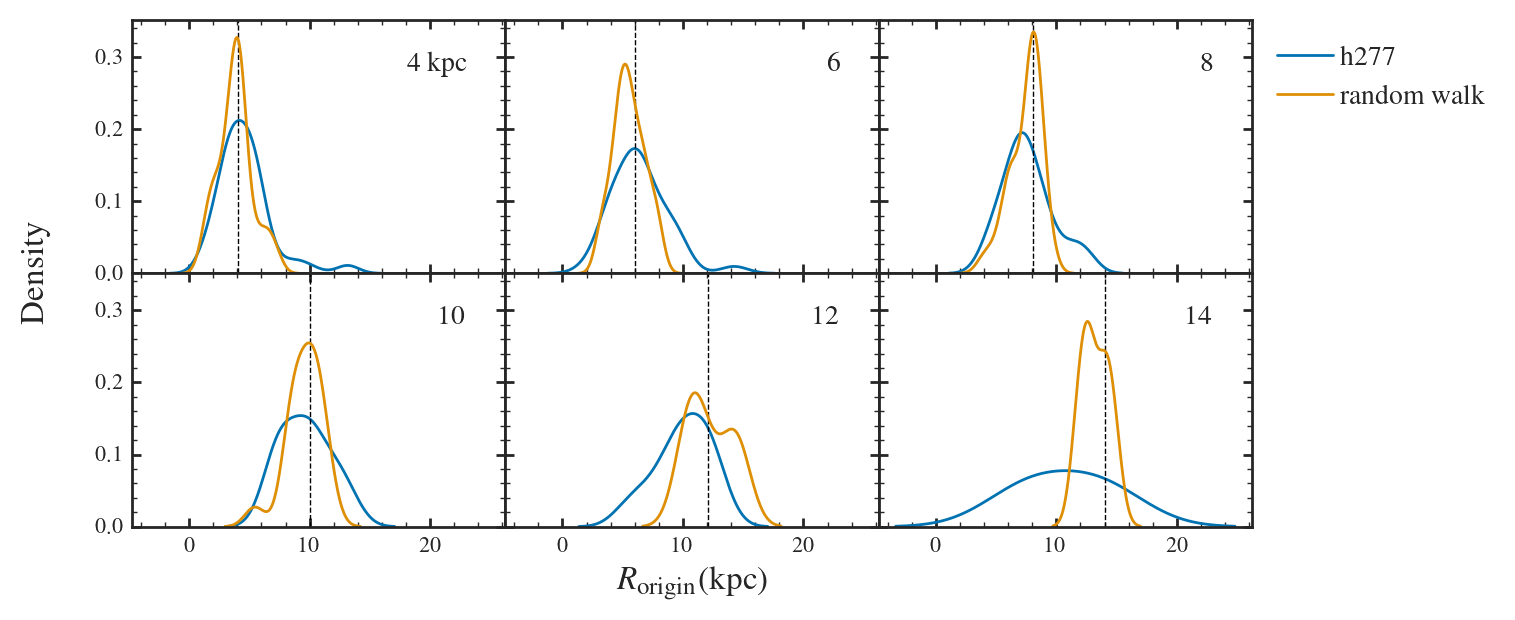

In [36]:
fig, axs = plt.subplots(2, 3, figsize=(7, 10/3), sharex=True, sharey=True, gridspec_kw={"hspace": 0, "wspace": 0})

for i in range(6):
    zone_id = [40, 60, 80, 100, 120, 140][i]
    plt.sca(axs[i//3][i%3])
    
    df = fiducial_all_stars[fiducial_all_stars.zone_final == zone_id]
    p = sns.kdeplot(df, x="r_origin", label="h277")
    plt.axvline(zone_id/10 + 0.05, color="k", ls="--", lw=0.5)

    df = gaussian_all_stars[gaussian_all_stars.zone_final == zone_id]
    p = sns.kdeplot(df, x="r_origin", label="random walk")

    text_str = "%2.0f" % (zone_id/10)
    if i == 0:
        text_str += " kpc"
    plt.text(0.9, 0.8, text_str, transform=plt.gca().transAxes, ha="right")
    
    plt.xlabel("")
    plt.ylabel("")
    


plt.sca(axs[0][2])
arya.Legend(loc=-1)
fig.supxlabel(r"$R_{\rm origin} ({\rm kpc})$")
fig.supylabel("Density")

plt.subplots_adjust(bottom=0.12, left=0.1)

plt.savefig("migration_comparison.pdf")

In [37]:
mig = pd.read_csv("../gauss_migration.txt")

Int64Index([   158,    159,   8158,   8159,  16158,  16159,  24158,  24159,
             32158,  32159,
            ...
            488158, 488159, 496158, 496159, 504158, 504159, 512158, 512159,
            520158, 520159],
           dtype='int64', name='N', length=132)

In [66]:
sns.kdeplot?

Signature:
sns.kdeplot(
    data=None,
    *,
    x=None,
    y=None,
    hue=None,
    weights=None,
    palette=None,
    hue_order=None,
    hue_norm=None,
    color=None,
    fill=None,
    multiple='layer',
    common_norm=True,
    common_grid=False,
    cumulative=False,
    bw_method='scott',
    bw_adjust=1,
    warn_singular=True,
    log_scale=None,
    levels=10,
    thresh=0.05,
    gridsize=200,
    cut=3,
    clip=None,
    legend=True,
    cbar=False,
    cbar_ax=None,
    cbar_kws=None,
    ax=None,
    **kwargs,
)
Docstring:
Plot univariate or bivariate distributions using kernel density estimation.

A kernel density estimate (KDE) plot is a method for visualizing the
distribution of observations in a dataset, analogous to a histogram. KDE
represents the data using a continuous probability density curve in one or
more dimensions.

The approach is explained further in the :ref:`user guide <tutorial_kde>`.

Relative to a histogram, KDE can produce a plot that is less cl

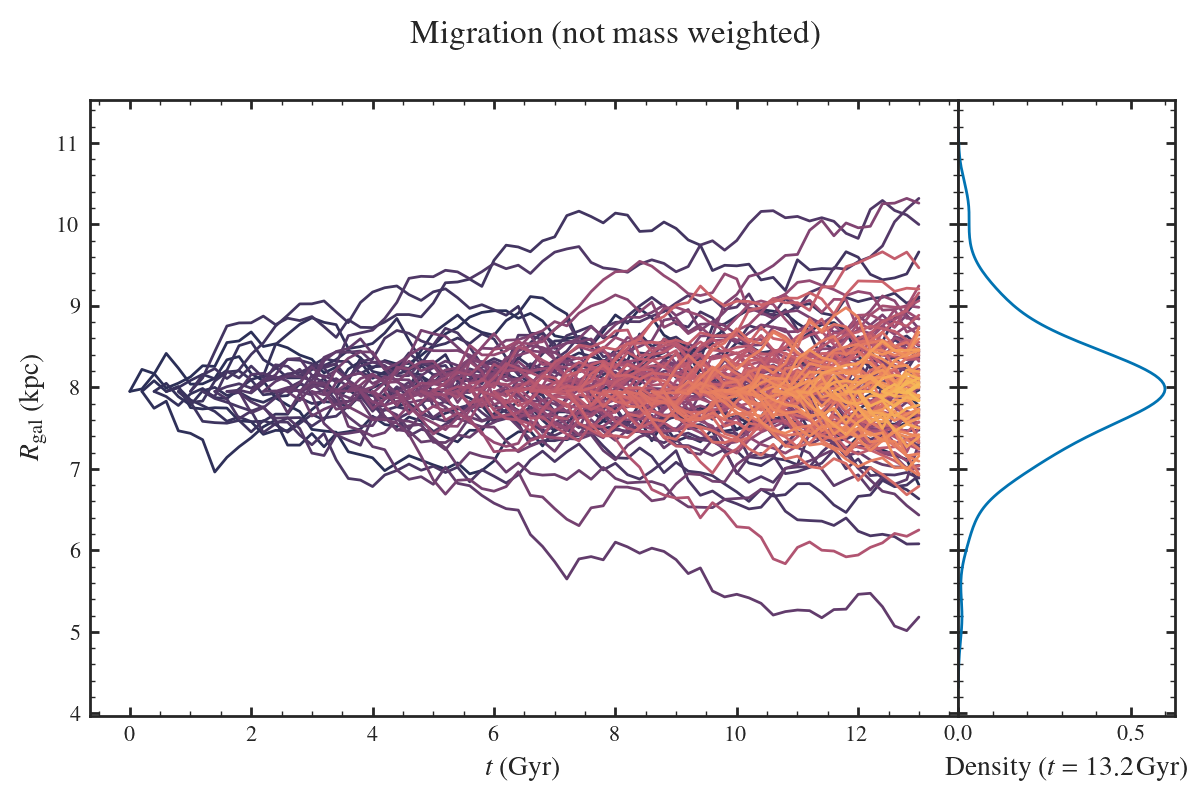

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(7, 4), width_ratios=[4, 1], sharey=True, gridspec_kw={"wspace": 0})

plt.sca(axs[0])
g = mig.groupby("N").first()
Ns = g[g.R == 7.95].index

for N in Ns:
    filt = mig.N == N
    solar_mig = mig[filt]
    hmap = arya.figure.colorbar.HueMap((0, 14))
    plt.plot(solar_mig.t, solar_mig.R, c=hmap(min(solar_mig.t)))
    
plt.xlabel(r"$t\;({\rm Gyr})$")
plt.ylabel(r"$R_{\rm gal}\; (\rm{kpc})$")

plt.sca(axs[1])

df = mig.groupby("N").last().loc[Ns]
sns.kdeplot(df, y="R")
plt.xlabel("Density ($t=13.2\,$Gyr)")

fig.suptitle("Migration (not mass weighted)")
plt.savefig("solar_migration_walks.pdf")

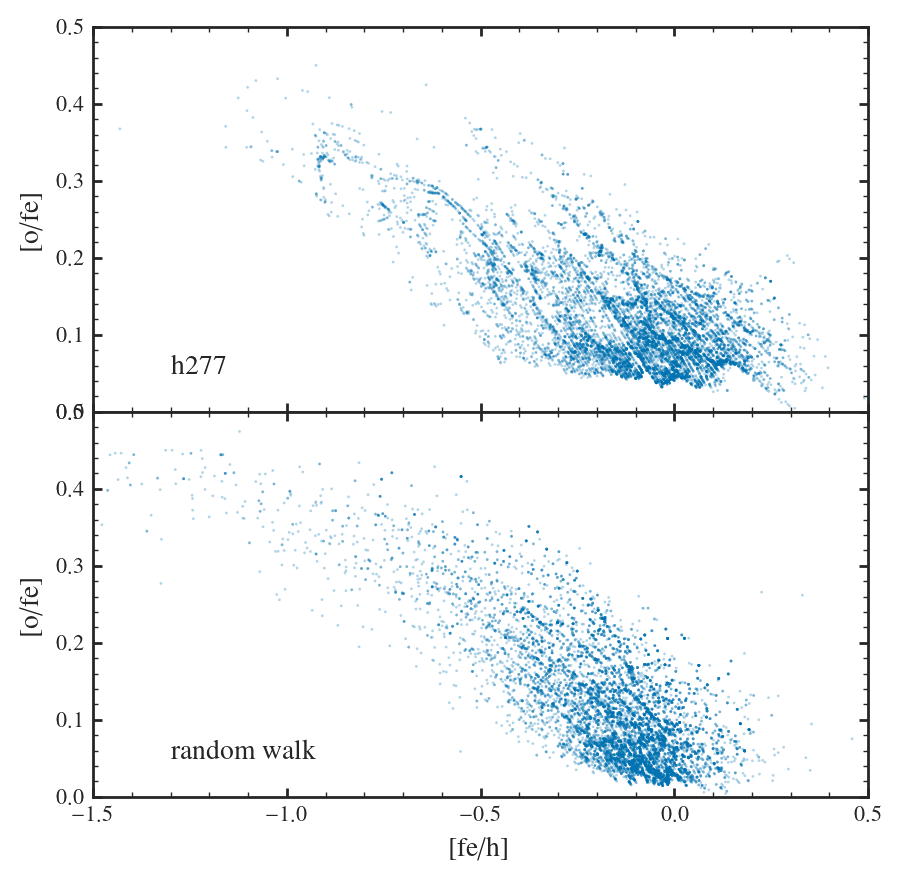

In [110]:
fig, axs = plt.subplots(2, 1, figsize=(5, 5), sharex=True, gridspec_kw={"hspace": 0})

plt.sca(axs[0])
sns.scatterplot(fiducial.stars, x="[fe/h]", y="[o/fe]", s=1, alpha=0.3, ec="none")
plt.xlim(-1.5, 0.5)
plt.ylim(0, 0.5)

plt.text(0.1, 0.1, "h277", transform=plt.gca().transAxes)


plt.sca(axs[1])
sns.scatterplot(gaussian.stars, x="[fe/h]", y="[o/fe]", s=1, alpha=0.3, ec="none")
plt.xlim(-1.5, 0.5)
plt.ylim(0, 0.5)

plt.text(0.1, 0.1, "random walk", transform=plt.gca().transAxes)


plt.savefig("ofefeh_migration.pdf")

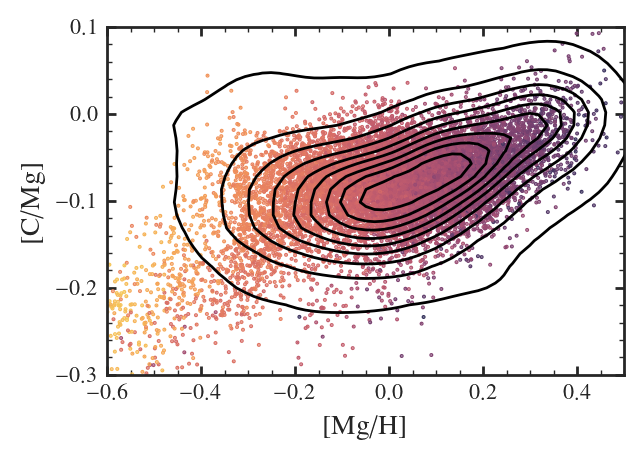

In [111]:
s = fiducial.stars
N = len(s)
dx = 0.03
dy = 0.03
aah.plot_contour("[mg/h]", "[c/mg]", zorder=3)

plt.scatter(s["[mg/h]"] + np.random.normal(0, dx, N), s["[c/mg]"] + np.random.normal(0, dy, N), 
             c = s["r_origin"], s=0.2, zorder=2)
plt.xlim(-0.6, 0.5)
plt.ylim(-0.3, 0.1)
plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

plt.savefig("fiducial_scatter.pdf")

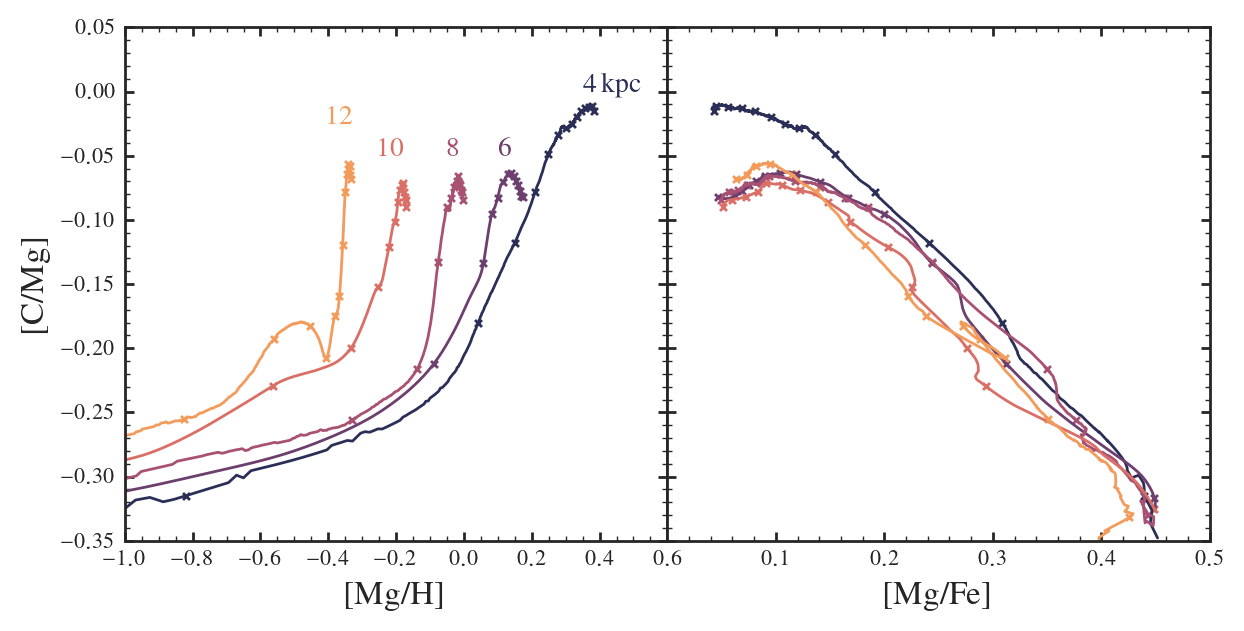

In [5]:

fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={"wspace": 0}, figsize=(7, 10/3))

plt.sca(axs[0])
fiducial.plot_R_slices("[mg/h]", "[c/mg]", legend=False)

colors = plt.get_cmap()(np.linspace(0.8, 0, 5))

coords = [
    (-0.4, -0.025),
    (-0.25, -0.05),
    (-0.05, -0.05),
    (0.1, -0.05),
    (0.35, 0.0)
]

texts = [
    "12",
    "10",
    "8",
    "6",
    r"4\,kpc"
]
for i in range(5):
    plt.text(*coords[i], texts[i], color=colors[i])

plt.xlabel(r"[Mg/H]")
plt.ylabel(r"[C/Mg]")
plt.xlim(-1, 0.6)
plt.ylim(-0.35, 0.05)


plt.sca(axs[1])
fiducial.plot_R_slices("[mg/fe]", "[c/mg]", legend=False)

plt.xlabel(r"[Mg/Fe]")
plt.ylabel("")
plt.xlim(0, 0.5)
plt.ylim(-0.35, 0.05)
plt.xticks(np.arange(0.1, 0.6, 0.1))

plt.savefig("evo_tracks.pdf")

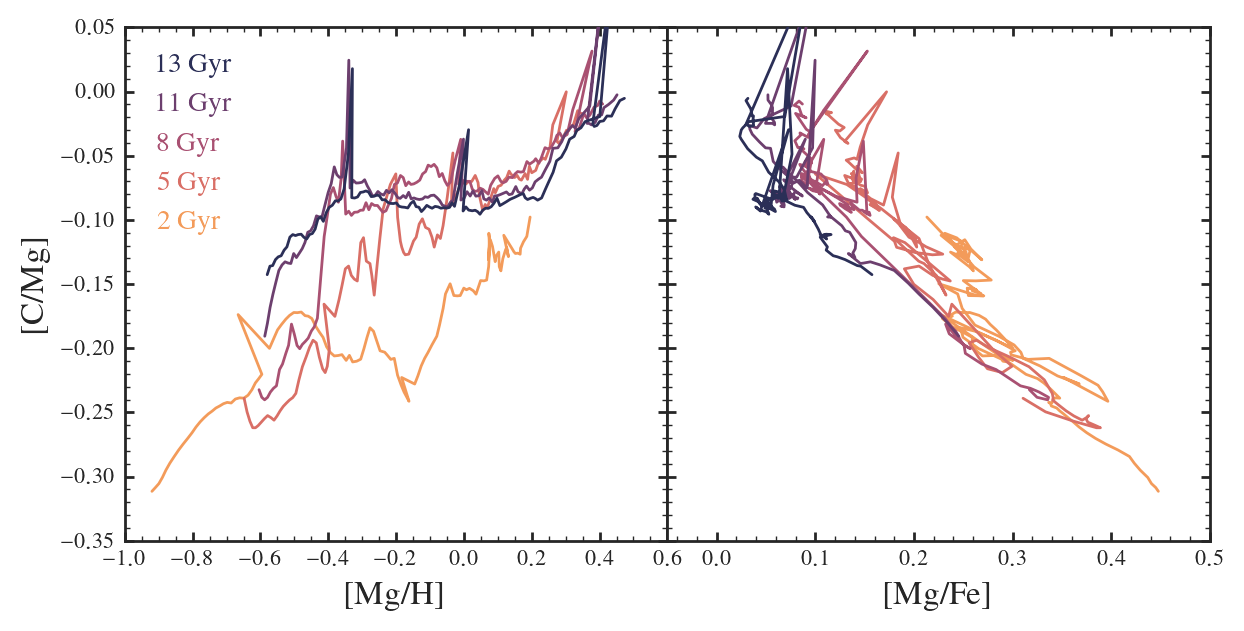

In [6]:
fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={"wspace": 0}, figsize=(7, 10/3))

plt.sca(axs[0])
fiducial.plot_t_slices("[mg/h]", "[c/mg]")




plt.xlabel(r"[Mg/H]")
plt.ylim(-0.35, 0.05)
plt.ylabel(r"[C/Mg]")
plt.xlim(-1, 0.6)

plt.sca(axs[1])


fiducial.plot_t_slices("[mg/fe]", "[c/mg]",legend=False)



plt.xlabel(r"[Mg/Fe]")
plt.ylabel("")
plt.xlim(-0.05, 0.5)

plt.savefig("evo_slices.pdf")

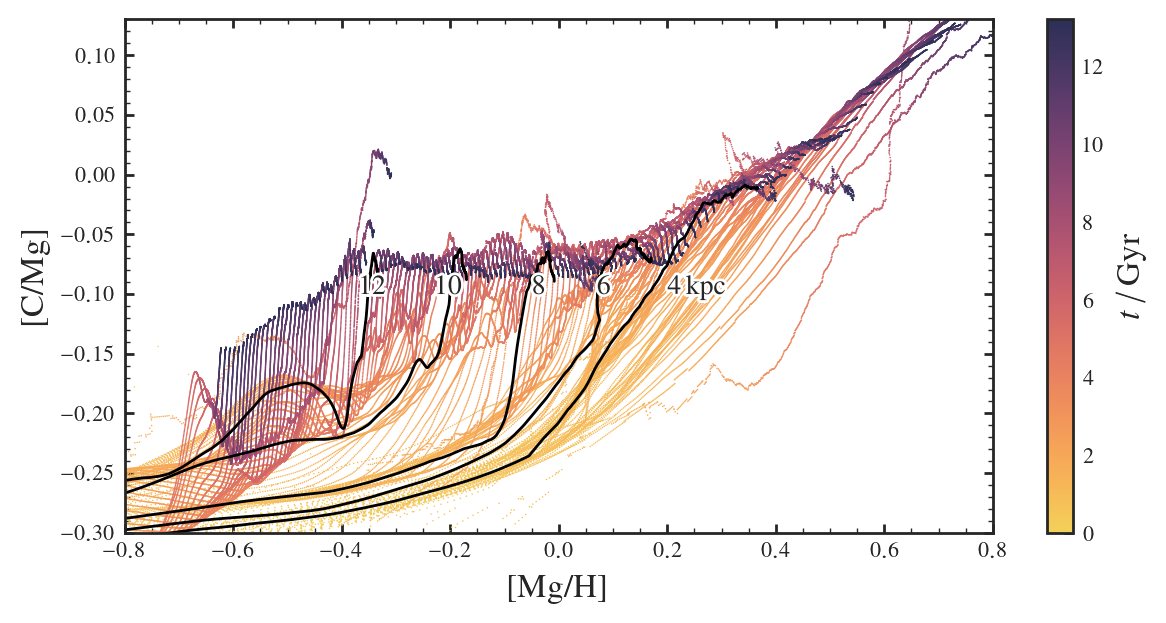

In [29]:
plt.figure(figsize=(7, 10/3))
h = fiducial.history

for R in [4, 6, 8, 10, 12]:
    df = h[np.isclose(h.R, R - 0.05)]
    plt.plot(df["[o/h]"], df["[c/o]"], color="k")

    
    
coords = [
    (-0.37, -0.1),
    (-0.23, -0.1),
    (-0.05, -0.1),
    (0.07, -0.1),
    (0.2, -0.1)
]

texts = [
    "12",
    "10",
    "8",
    "6",
    r"4\,kpc"
]

for i in range(5):
    text = plt.text(*coords[i], texts[i])
    text.set_path_effects([mpl.patheffects.Stroke(linewidth=2, foreground='w'),
                   mpl.patheffects.Normal()])

sns.scatterplot(h, x="[o/h]", y="[c/o]", hue="time", s=0.3, alpha=1, legend=False, edgecolor="none", palette="arya_r")
plt.xlim(-0.8, 0.8)
plt.ylim(-0.3, 0.13)
arya.Colorbar(clim=(0, 13.2), label=r"$t\,/\,{\rm Gyr}$", cmap="arya_r")


plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

plt.savefig("all_the_tracks.pdf")

(-0.3, 0.13)

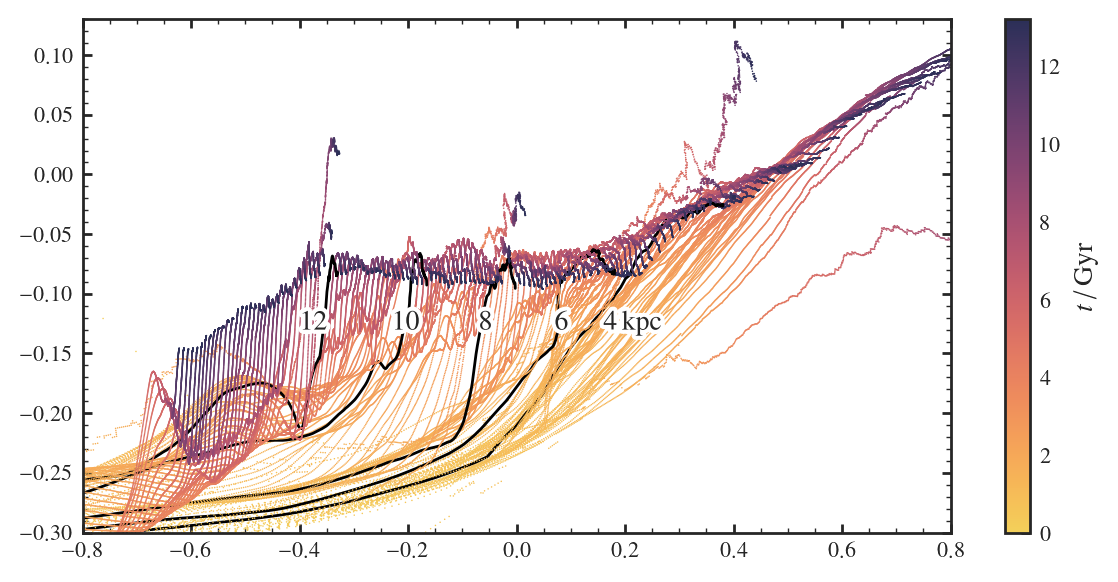

In [61]:
plt.figure(figsize=(7, 10/3))


h = fiducial.history
cb = arya.Colorbar(clim=(0, 13.2), label=r"$t\,/\,{\rm Gyr}$", cmap="arya_r")

for R in np.sort(h.R.unique()):
    dfa = h[h.R == R]
    if any(np.isclose(R+0.05, [4, 6, 8, 10, 12])):
        plt.plot(dfa["[mg/h]"], dfa["[c/mg]"], lw=1, c="k", zorder=1)
    else:
        plt.scatter(dfa["[mg/h]"], dfa["[c/mg]"], s=0.3, c=cb(dfa.time), ec="none", zorder=1)
    
coords = [
    (-0.4, -0.13),
    (-0.23, -0.13),
    (-0.07, -0.13),
    (0.07, -0.13),
    (0.16, -0.13)
]

texts = [
    "12",
    "10",
    "8",
    "6",
    r"4\,kpc"
]

for i in range(5):
    text = plt.text(*coords[i], texts[i])
    text.set_path_effects([mpl.patheffects.Stroke(linewidth=3, foreground='w'),
                   mpl.patheffects.Normal()])
    
plt.xlim(-0.8, 0.8)
plt.ylim(-0.3, 0.13)

In [12]:
plt.figure(figsize=(7, 10/3))


h = fiducial.history
cb = arya.Colorbar(clim=(0, 13.2), label=r"$t\,/\,{\rm Gyr}$", cmap="arya_r")

coords = []
for R in np.sort(h.R.unique()):
    dfa = h[h.R == R]
    if any(np.isclose(R+0.05, [4, 6, 8, 10, 12])):
        plt.scatter(dfa["[o/fe]"], dfa["[c/o]"], lw=1, c=cb(dfa.time), zorder=1)
        coords.append((dfa["[o/fe]"][-1], dfa["[c/o]"][-1]))
    else:
        pass
        # plt.scatter(dfa["[o/fe]"], dfa["[c/o]"], s=0.3, c=cb(dfa.time), ec="none", zorder=1)
    

texts = [
    "12",
    "10",
    "8",
    "6",
    r"4\,kpc"
]

for i in range(5):
    text = plt.text(*coords[i], texts[i])
    text.set_path_effects([mpl.patheffects.Stroke(linewidth=3, foreground='w'),
                   mpl.patheffects.Normal()])
    
plt.xlim(-0.0, 0.3)
plt.ylim(-0.15, 0.)
plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")
plt.savefig("coofe_tracks.pdf")